# Adjusting debiasers

The following notebook provides some insights into how to adjust parameters to modify debiasers. 

For in-depth information about the debiasers and their usage refer to the API reference of the debias-module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Read in data

We start by reading in and preprocessing some data. For an explanation of the steps please refer to the "Getting started" notebook.

In [10]:
import sys
sys.path.append("../")  # path contains python_file.py

import iris

# Given an iris-cube this returns the dates stored in the last time-dimension
def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

get_dates = np.vectorize(get_dates)

# Reads in the testing-data from ISIMIP stored in testing_data/ISIMIP
def read_in_and_preprocess_testing_data(variable, isimip_data_path = "testing_data/ISIMIP/"):
    
    # Load in data
    obs = iris.load_cube(isimip_data_path+variable+"_obs-hist_coarse_1979-2014.nc")
    cm_hist = iris.load_cube(isimip_data_path+variable+"_sim-hist_coarse_1979-2014.nc")
    cm_future = iris.load_cube(isimip_data_path+variable+"_sim-fut_coarse_2065-2100.nc")

    # Extract dates
    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future)
    }
    
    # Convert to np.array (from masked-array)
    obs = obs.data
    cm_hist = cm_hist.data
    cm_future = cm_future.data

    # Move time to first axis (our convention)
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)
    
    return obs, cm_hist, cm_future, dates

## 1. A first example

Every debiaser is a subclass of the abstract `Debiaser` class. This provides a unified interface for initialising and applying debiasers. Let's read in some temperature data:

In [11]:
obs, cm_hist, cm_future, dates = read_in_and_preprocess_testing_data("tas")

We can initialise a debiaser for `"tas"` by using the `from_variable` method. If we want to apply ISIMIP and ECDFM we can write:

In [12]:
from PACKAGE_NAME.debias import ECDFM, ISIMIP, DeltaChange

debiaser1 = ECDFM.from_variable("tas")
debiaser2 = ISIMIP.from_variable("tas")

Applying the debiasers works using the `apply`-classmethod.

In [14]:
debiased_cm_future1 = debiaser1.apply(obs, cm_hist, cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]


Some debiasers like ISIMIP require additional arguments in the apply-method like the dates:

In [15]:
debiased_cm_future2 = debiaser2.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.96s/it]


We can compare the distribution of the debiased data at location [1,1]:

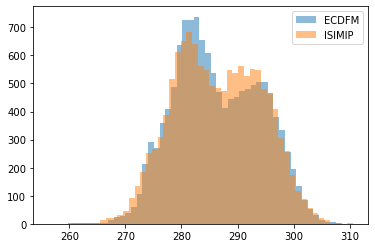

In [6]:
plt.hist(debiased_cm_future1[:, 1, 1], bins="auto", alpha = 0.5, label = "ECDFM")
plt.hist(debiased_cm_future2[:, 1, 1], bins="auto", alpha = 0.5, label = "ISIMIP")
plt.legend()
plt.show()

We see that the data distributions produced by ECDFM and ISIMIP do differ. For info on how to evaluate this have a look at TODO.

## 2. Debiasers

### 2.1. Initialisation

Every debiaser that is part of the package consists of a set of parameters controlling the behavior as well as a `from_variable` and `apply`-method. Let's have a look at what happens when we initialise the ECDFM debiaser from above:

In [16]:
debiaser1 = ECDFM.from_variable("tas")
debiaser1

ECDFM(variable='Daily mean near-surface air temperature', reasonable_physical_range=[0, 400], distribution=<scipy.stats._continuous_distns.beta_gen object at 0x7f6d51d6a1c0>)

We see that two parameters are set: a variable referring to the variable we are debiasing, as well as a distribution. It is also possible to initialise the debiaser directly with those parameters:

In [17]:
import scipy.stats
debiaser2 = ECDFM(distribution=scipy.stats.beta)

debiaser1 == debiaser2

True

The debiaser initialised by setting parameters explictly is the same as the one using `from_variable`.

Every debiaser has default arguments for a subset of climatic variables. The `from_variable` method initialises a debiaser for a variable using those default arguments. Below is shown for which debiasers and variables currently default settings exist:

TODO: Insert table

For example we can easily instantiate a `QuantileDeltaMapping` debiaser for precipitation:

In [18]:
from PACKAGE_NAME.debias import QuantileDeltaMapping

pr_debiaser = QuantileDeltaMapping.from_variable("pr")

But not an ISIMIP debiaser for tasmin:

In [19]:
debiaser3 = ISIMIP.from_variable("tasmin")

ValueError: Unfortunately currently no default settings exist for the variable 'tasmin' in the debiaser ISIMIP. You can set the required class parameters manually by using the class constructor. This also allows more fine-grained optimization of the debiaser.

ISIMIP instead offers the option to debias `tasrange` and `tasskew` and calculate `tasmin` from those.

Some debiasers offer additionally a `for_precipitation` to initialise it to apply it to precipitation (`pr`). Precipitation methods can be a bit more complicated and sometimes require the specification of a threshold under which it is assumed zero. The `for_precipitation`-method is there to make the choice of method and initialisation easier.

For example we can initialise a `QuantileMapping` debiaser applying quantile mapping using a precipitation gamma hurdle model: a two step model where binomially it is decided whether it rains or not and then a gamma distribution is assumed for the amounts:

In [21]:
from PACKAGE_NAME.debias import QuantileMapping

# Read in some pr-data
obs, cm_hist, cm_future, dates = read_in_and_preprocess_testing_data("pr")

# Initialise debiaser
pr_debiaser1 = QuantileMapping.for_precipitation(model_type = "hurdle")

# Apply:
debiased_pr1 = pr_debiaser1.apply(obs, cm_hist, cm_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 43.48it/s]


and compare it with a censored model for precipitation: where all precipitation amounts under a threshold (so also all dry days) are assumed censored:

In [22]:
# Initialise debiaser
pr_debiaser2 = QuantileMapping.for_precipitation(model_type = "censored", censoring_threshold = 0.1/86400) # We are working with precipitation flux

# Apply:
debiased_pr2 = pr_debiaser2.apply(obs, cm_hist, cm_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


We can compare the two at location `[1,1]`:

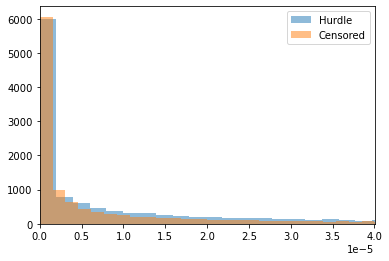

In [23]:
# Compare the two at location [1,1]:
plt.hist(debiased_pr1[:, 1, 1], bins="auto", alpha = 0.5, label = "Hurdle")
plt.hist(debiased_pr2[:, 1, 1], bins="auto", alpha = 0.5, label = "Censored")
plt.xlim(0, 0.00004)
plt.legend()
plt.show()

### 2.2. Apply

Applying the debiaser is easy with the apply-function. Lets initialise and apply a `DeltaChange` debiaser for `"tas"`:

In [24]:
obs, cm_hist, cm_future, dates = read_in_and_preprocess_testing_data("tas")

debiaser = DeltaChange.from_variable("tas")

debiased_cm_future = debiaser.apply(obs, cm_hist, cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 5241.24it/s]


The apply function always needs three numpy arrays of data in the form: 

- obs representing observations of a climatological variable
- cm_hist representing climate model values for a climatological variable during a reference/the observational period
- cm_future representing climate model values for a climatological variable during a future period/period to debias

obs and cm_hist are used to calculate the bias for the climate model and to transform the future values. How this is done differs from case to case.
All three are assumed to be 3d-numpy arrays where the first dimension corresponds to time and the other two to spatial locations. The locations in obs, cm_hist  and cm_future need to be the same and observational data should be interpolated to the climate model grid prior to applying (TODO: true?). For how to do that see TODO.

Besides obs, cm_hist and cm_future some debiasers might also require additional information like the dates to which observations and cm_values correspond, to for example apply the debiaser in a running window-mode. For example ISIMIP requires the dates as additional input:

In [25]:
debiaser = ISIMIP.from_variable("tas")
debiased_cm_future = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.87s/it]


here dates just contains arrays of dates corresponding to values in obs, cm_hist, cm_future. It can be one of multiple date-formats:

In [26]:
dates

{'time_obs': array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(1979, 1, 2, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(1979, 1, 3, 0, 0, 0, 0, has_year_zero=True),
        ...,
        cftime.DatetimeProlepticGregorian(2014, 12, 29, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(2014, 12, 30, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
       dtype=object),
 'time_cm_hist': array([cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(1979, 1, 2, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(1979, 1, 3, 0, 0, 0, 0, has_year_zero=True),
        ...,
        cftime.DatetimeProlepticGregorian(2014, 12, 29, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeProlepticGregorian(201

However ISIMIP also runs without the dates, by inferring them:

In [27]:
debiaser = ISIMIP.from_variable("tas")
debiased_cm_future = debiaser.apply(obs, cm_hist, cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
  0%|                                                                                                                                                                                | 0/4 [00:00<?, ?it/s]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time inf

What debiasers might additionally need is specified inside the documentation for each of the debiases: TODO

It is possible to change the verbosity with which a debiaser works, supressing info or warnings. Running the same debiaser as above, but only printing out ERROR messages:

In [28]:
debiaser = ISIMIP.from_variable("tas")
debiased_cm_future = debiaser.apply(obs, cm_hist, cm_future, verbosity = "ERROR")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.81s/it]


## 3. Ways of initializing / adjusting parameters

As seen above it is possible to initialise a debiaser either using the `from_variable`-method or the class-constructor: 

In [29]:
from PACKAGE_NAME.debias import QuantileDeltaMapping

debiaser1 = QuantileDeltaMapping.from_variable("tas")
debiaser2 = QuantileDeltaMapping(distribution = scipy.stats.norm, trend_preservation = "absolute")
debiaser1 == debiaser2

True

Using the class constructor it is possible to extend debiasers to meteorological variables which are not currently covered by default arguments of the debiaser. TODO: example?

In many cases it is and will be important to modify the behavior of debiasers to make it work better for a certain variable/region and problem at hand. In parametric methods we might want to change the distribution to improve fit eg. for extremes, we might want to use a different trend-capturing method if trends are unrealistic, modified or inflated, or just generally might want to do some additional adjustment the debiaser offers. Parameters of the debiaser can be modified either by setting them differently in the class constructor or in the `from_variable`-method. For example if we decide to apply `QuantileMapping` and the climate change trend of the model is not entirely realistic it might be a good idea not to use detrending prior to quantile mapping. This can be done as:

In [30]:
new_qm_debiaser1 = QuantileMapping.from_variable("tas", detrending = "no_detrending")

or:

In [31]:
new_qm_debiaser2 = QuantileMapping(distribution = scipy.stats.norm, detrending = "no_detrending")
new_qm_debiaser1 == new_qm_debiaser2

True

It is also possible to directly modify the class attribute: 

In [32]:
new_qm_debiaser3 = QuantileMapping.from_variable("tas")
new_qm_debiaser3.detrending = "no_detrending"

new_qm_debiaser1 == new_qm_debiaser3

True

However no validation is happening on the new arguments, so this method is generally not recommended.

Some debiasers have many parameters to control the behavior, but oftentimes only a few are central. The documentation for each of the debiasers provides an indication of the central and required parameters and how they modify the debiasing behavior.

- TODO: do we have some general guidelines on what to change
- TODO: recommendations on iterative workflow
- TODO: example with better tail behavior?